## Import

In [2]:
import beamtest_analysis_helper as helper
from glob import glob
from natsort import natsorted
import pandas as pd
import hist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import mplhep as hep
hep.style.use('CMS')

In [3]:
chip_labels = [0, 1, 2, 3]
chip_names = ["ET2_EPIR_Pair1", "ET2_BAR_4", "ET2_BAR_6", "ET2_CNM_1-3"]
offsets = [15, 6, 15, 6]
high_voltages = [260, 260, 260, 200]

fig_path = './'

chip_fignames = chip_names
chip_figtitles = [
    f"(Trigger) Pair1 HV{high_voltages[0]}V OS:{offsets[0]}",
    f"Bar4 HV{high_voltages[1]}V OS:{offsets[1]}",
    f"Bar6 HV{high_voltages[2]}V OS:{offsets[2]}",
    f"CNM (HPK) 1-3 HV{high_voltages[3]}V OS:{offsets[3]}"]

## Loading dataframe: No trigger, No event

In [18]:
files = glob('./desy_TB_run12/Run_12_loop_[4-6].feather')

last_evt = 0
dataframes = []

for idx, ifile in enumerate(files):
    tmp_df = pd.read_feather(ifile)
    tmp_df.drop(columns=['evt_number', 'bcid', 'l1a_counter', 'ea'], inplace=True)

    if idx > 0:
        tmp_df['evt'] += last_evt
    last_evt += tmp_df['evt'].unique()[-1]

    event_board_counts = tmp_df.groupby(['evt', 'board']).size().unstack(fill_value=0)

    base_selection = (event_board_counts[0] >= 1) # event must have at least one hit from the trigger board
    selected_event_numbers = event_board_counts[base_selection].index
    selected_subset_df = tmp_df[tmp_df['evt'].isin(selected_event_numbers)]
    selected_subset_df.reset_index(inplace=True, drop=True)

    dataframes.append(selected_subset_df)
    del tmp_df, event_board_counts, base_selection, selected_event_numbers, selected_subset_df

df = pd.concat(dataframes)
df.reset_index(inplace=True, drop=True)
del dataframes

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10135280 entries, 0 to 10135279
Data columns (total 7 columns):
 #   Column  Dtype
---  ------  -----
 0   evt     int64
 1   board   int64
 2   row     int64
 3   col     int64
 4   toa     int64
 5   tot     int64
 6   cal     int64
dtypes: int64(7)
memory usage: 541.3 MB


In [ ]:
helper.plot_number_of_fired_board(df)

In [ ]:
helper.plot_number_of_hits_per_event(df, chip_figtitles=chip_figtitles)

In [ ]:
helper.plot_2d_nHits_nBoard(df, chip_figtitles=chip_figtitles)

In [ ]:
h_inclusive = helper.return_hist(df, chip_names, chip_labels, hist_bins=[100, 128, 128])

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[0], chip_fignames[0], chip_figtitles[0], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[1], chip_fignames[1], chip_figtitles[1], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[2], chip_fignames[2], chip_figtitles[2], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[3], chip_fignames[3], chip_figtitles[3], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

del h_inclusive

In [ ]:
helper.plot_heatmap_byPandas(df, chipLabels=chip_labels, figtitle=chip_figtitles, figtitle_tag='inclusive')

## Check noise

In [ ]:
tdc_cuts = {
    # board ID: [CAL LB, CAL UB, TOA LB, TOA UB, TOT LB, TOT UB]
    0: [0, 1100,   0, 1100, 0, 600],
    1: [0, 1100,   0, 1100, 0, 100], # pixel (15, 6), (15, 7) Sep 28th data
    2: [0, 1100,   0, 1100, 0, 600],
    3: [0, 1100,   0, 1100, 0, 100],
}

filtered_df = helper.tdc_event_selection(df, tdc_cuts_dict=tdc_cuts)

In [ ]:
h_inclusive = helper.return_hist(filtered_df, chip_names, chip_labels, hist_bins=[100, 128, 128])

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[0], chip_fignames[0], chip_figtitles[0], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[1], chip_fignames[1], chip_figtitles[1], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[2], chip_fignames[2], chip_figtitles[2], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[3], chip_fignames[3], chip_figtitles[3], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

del h_inclusive

In [ ]:
helper.plot_heatmap_byPandas(filtered_df, chipLabels=chip_labels, figtitle=chip_figtitles, figtitle_tag='')

In [ ]:
del filtered_df

## Single hit on the trigger board and hit >= 1 on the reference board

In [21]:
## Selecting good hits
tdc_cuts = {
    # board ID: [CAL LB, CAL UB, TOA LB, TOA UB, TOT LB, TOT UB]
    0: [df.loc[df['board'] == 0]['cal'].mode()[0]-50, df.loc[df['board'] == 0]['cal'].mode()[0]+50,   0, 1100, 0, 600],
    1: [df.loc[df['board'] == 1]['cal'].mode()[0]-50, df.loc[df['board'] == 1]['cal'].mode()[0]+50,   0, 1100, 0, 600],
    2: [df.loc[df['board'] == 2]['cal'].mode()[0]-50, df.loc[df['board'] == 2]['cal'].mode()[0]+50,   0, 1100, 0, 600],
    3: [df.loc[df['board'] == 3]['cal'].mode()[0]-50, df.loc[df['board'] == 3]['cal'].mode()[0]+50,   0, 1100, 0, 600],
}

filtered_df = helper.tdc_event_selection(df, tdc_cuts_dict=tdc_cuts)

In [22]:
event_board_counts = filtered_df.groupby(['evt', 'board']).size().unstack(fill_value=0)
event_selection_col = None

trig_selection = (event_board_counts[0] == 1)
ref_selection = (event_board_counts[2] >= 1)
event_selection_col = trig_selection & ref_selection

selected_event_numbers = event_board_counts[event_selection_col].index
selected_subset_df = filtered_df[filtered_df['evt'].isin(selected_event_numbers)]
selected_subset_df.reset_index(inplace=True, drop=True)
del filtered_df

In [23]:
## Temporary cell
raw_df = df

In [ ]:
h_inclusive = helper.return_hist(selected_subset_df, chip_names, chip_labels, hist_bins=[100, 128, 128])

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[0], chip_fignames[0], chip_figtitles[0], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[1], chip_fignames[1], chip_figtitles[1], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[2], chip_fignames[2], chip_figtitles[2], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

helper.plot_1d_TDC_histograms(h_inclusive, chip_names[3], chip_fignames[3], chip_figtitles[3], fig_path, save=False, show=True,
                                tag="inclusive", title_tag=", inclusive", slide_friendly=True)

del h_inclusive

In [ ]:
del selected_subset_df

In [24]:
df = selected_subset_df

In [ ]:
event_board_counts = filtered_df.groupby(['evt', 'board']).size().unstack(fill_value=0)
event_selection_col = None

for board in [0, 2]:
    if board not in event_board_counts:
        event_selection_col = 1
        continue
    if event_selection_col is None:
        event_selection_col = (event_board_counts[board] == 1)
    else:
        event_selection_col = event_selection_col & (event_board_counts[board] == 1)

selected_event_numbers = event_board_counts[event_selection_col].index
selected_subset_df = filtered_df[filtered_df['evt'].isin(selected_event_numbers)]
selected_subset_df.reset_index(inplace=True, drop=True)
del df

In [ ]:
df = selected_subset_df
del selected_subset_df

## Correlation trigger

In [ ]:
h_test1 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 row', label='Trigger Board Row'),
    hist.axis.Regular(16, 0, 16, name='b2 row', label='Reference Board Row'),
)
h_test1.fill(df.loc[df['board'] == 0]['row'], df.loc[df['board'] == 2]['row'])

h_test2 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 col', label='Trigger Board Col'),
    hist.axis.Regular(16, 0, 16, name='b2 col', label='Reference Board Col'),
)
h_test2.fill(df.loc[df['board'] == 0]['col'], df.loc[df['board'] == 2]['col'])

In [ ]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_test1, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
# ax[0].set_title(f"{chip_figtitle}, CAL{title_tag}", loc="right", size=15)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_test2, ax=ax[1])
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

In [ ]:
h_dis = hist.Hist(
    hist.axis.Regular(64, 0, 32, name='dis', label='Distance (Trigger - Reference)'),
)
dis = np.sqrt((df.loc[df['board'] == 0]['row'].values - df.loc[df['board'] == 2]['row'].values)**2 + (df.loc[df['board'] == 0]['col'].values - df.loc[df['board'] == 2]['col'].values)**2)
h_dis.fill(dis)

In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(15, 8))
hep.histplot(h_dis, ax=ax)
hep.cms.text(loc=0, ax=ax, text="Preliminary", fontsize=25)
ax.set_yscale('log')

## Correlation trigger + multiple hits on reference

In [27]:
n = int(0.01*df.shape[0]) # ~100k events
indices = np.random.choice(df['evt'].unique(), n, replace=False)
test_df = df.loc[df['evt'].isin(indices)]

In [28]:
h_test1 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 row', label='Trigger Board Row'),
    hist.axis.Regular(16, 0, 16, name='b2 row', label='Reference Board Row'),
)
h_test2 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 col', label='Trigger Board Col'),
    hist.axis.Regular(16, 0, 16, name='b2 col', label='Reference Board Col'),
)
h_dis = hist.Hist(
    hist.axis.Regular(64, 0, 32, name='dis', label='Distance (Trigger - Reference)'),
)

In [31]:
for name, group in test_df.groupby('evt'):

    cnt = len(group[group['board'] == 2]['row'])

    broadcasted_trig_row = np.full(cnt, group.loc[group['board'] == 0]['row'].values)
    broadcasted_trig_col = np.full(cnt, group.loc[group['board'] == 0]['col'].values)
    h_test1.fill(broadcasted_trig_row, group.loc[group['board'] == 2]['row'].to_numpy())
    h_test2.fill(broadcasted_trig_col, group.loc[group['board'] == 2]['col'].to_numpy())

    dis = np.sqrt((broadcasted_trig_row - group.loc[group['board'] == 2]['row'].values)**2 + (broadcasted_trig_col - group.loc[group['board'] == 2]['col'].values)**2)
    h_dis.fill(dis)

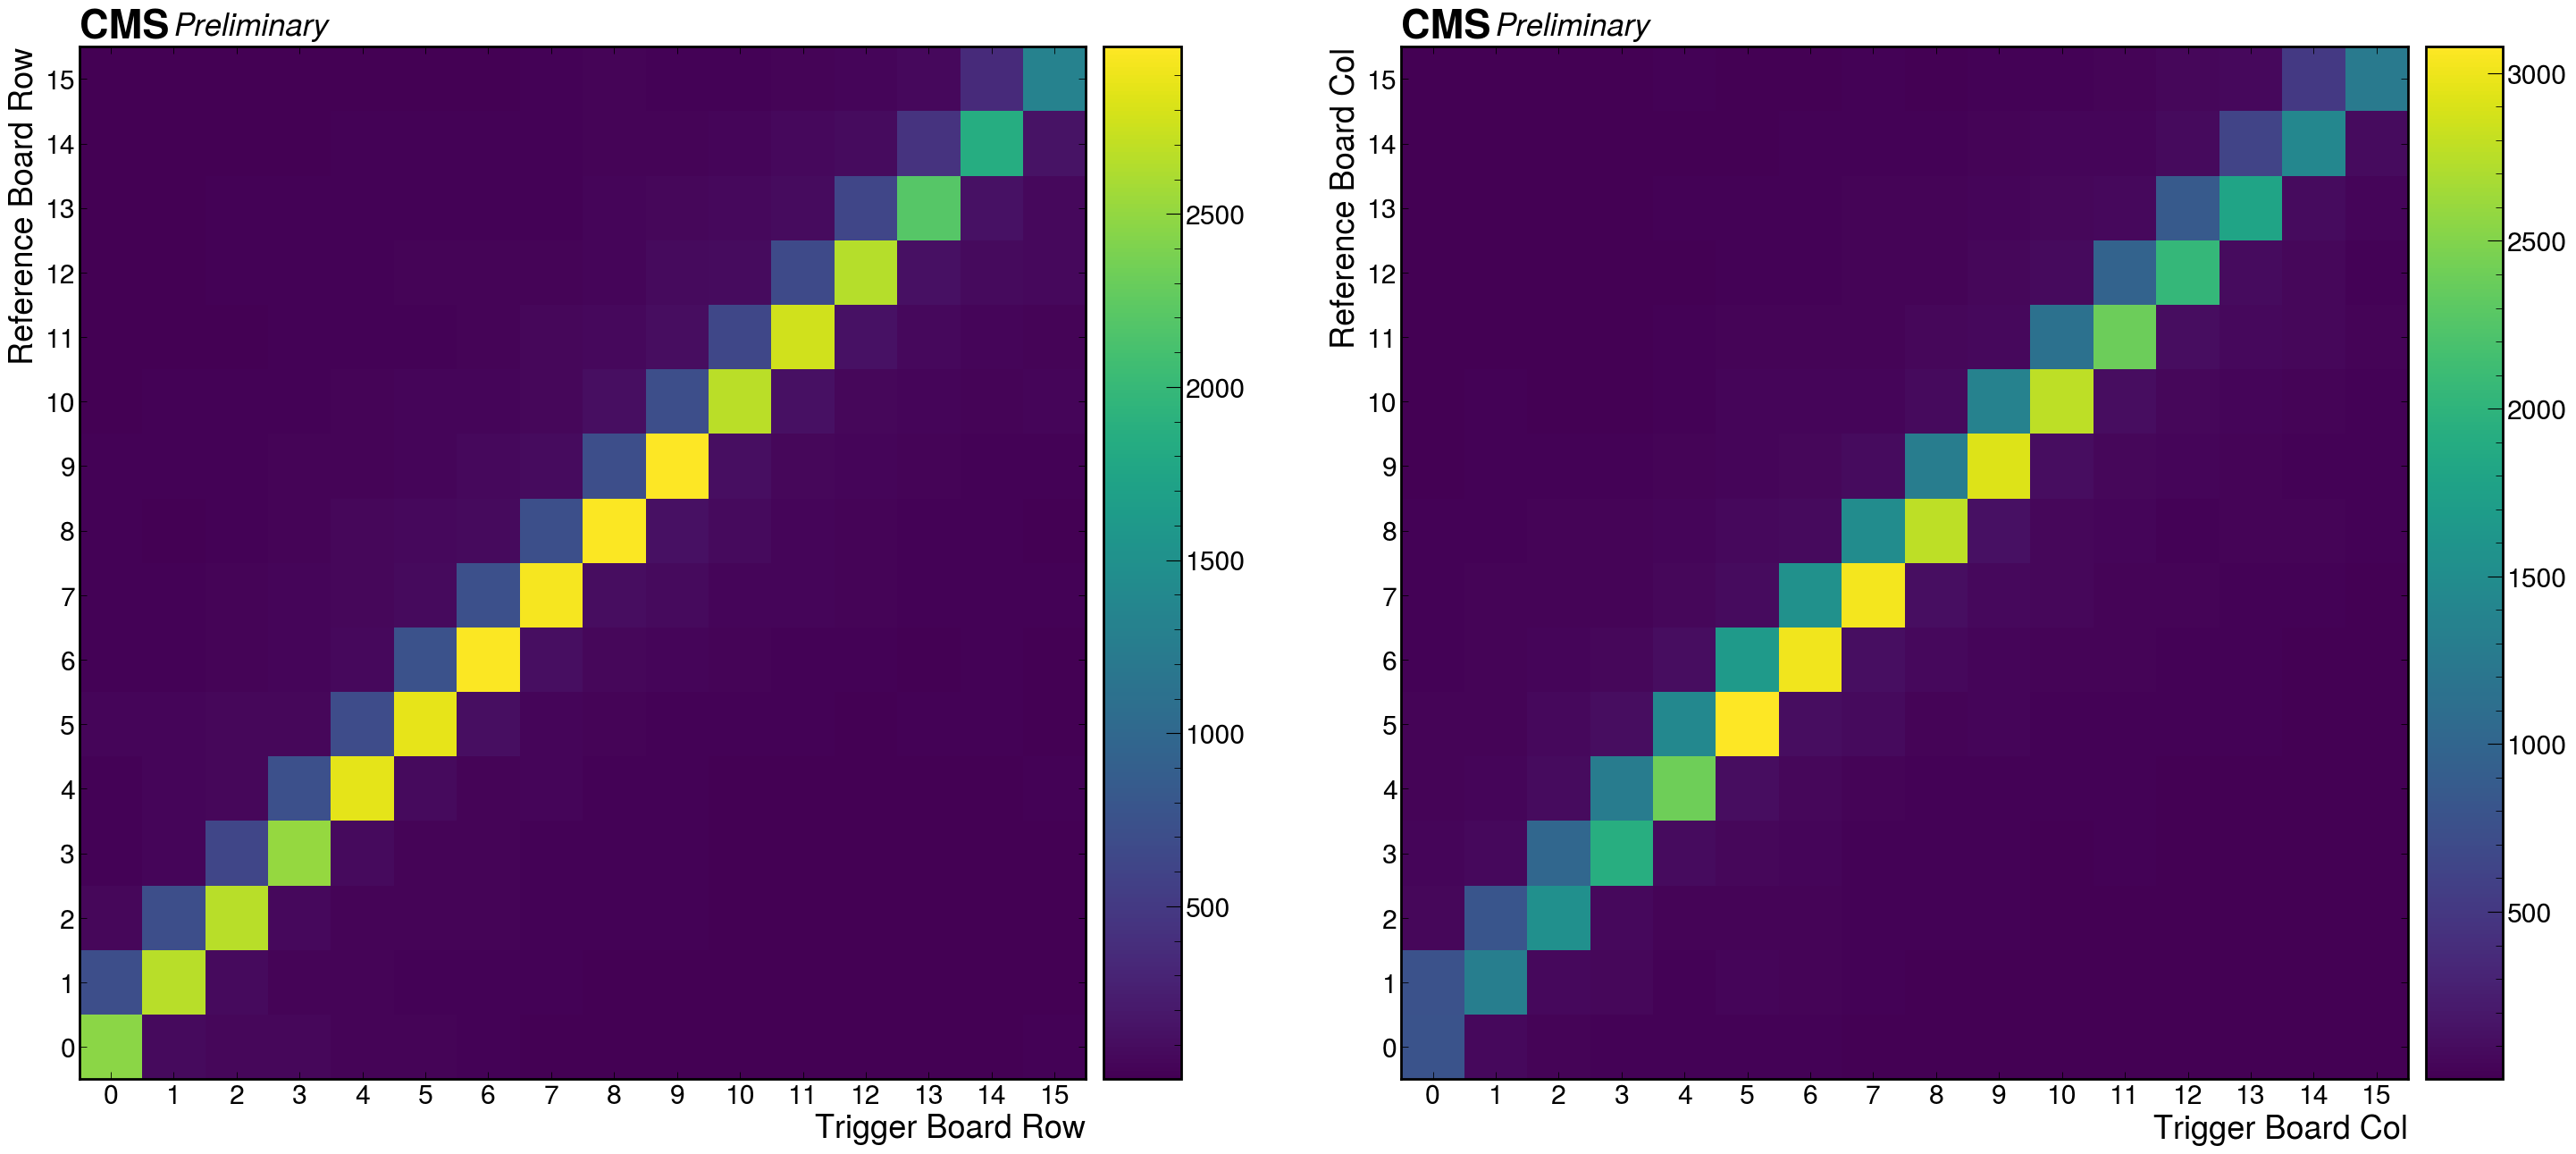

In [32]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_test1, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
# ax[0].set_title(f"{chip_figtitle}, CAL{title_tag}", loc="right", size=15)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_test2, ax=ax[1])
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

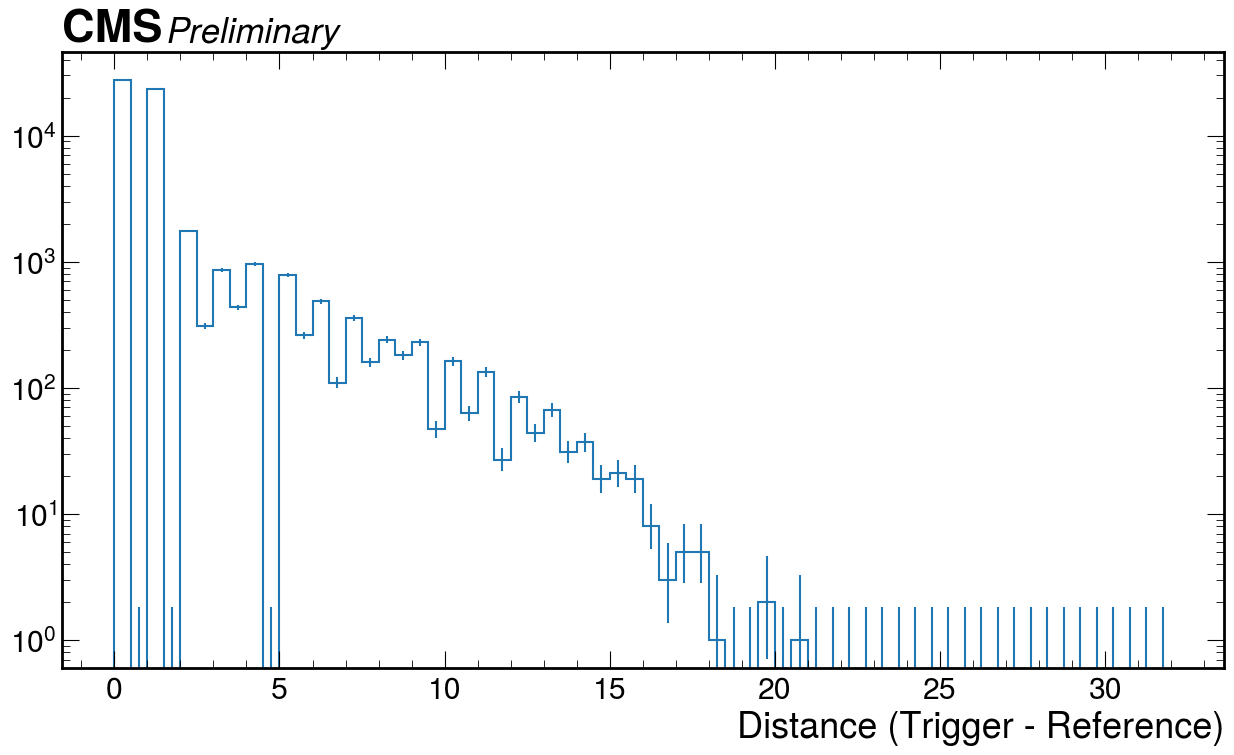

In [33]:
fig, ax = plt.subplots(dpi=100, figsize=(15, 8))
hep.histplot(h_dis, ax=ax)
hep.cms.text(loc=0, ax=ax, text="Preliminary", fontsize=25)
ax.set_yscale('log')

In [ ]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_test1, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_test2, ax=ax[1])
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

In [ ]:
df.info()

In [ ]:
event_board_counts = df.groupby(['evt', 'board']).size().unstack(fill_value=0)
b1_plus1hit_cut = event_board_counts[1] >= 1
b1_plus2hit_cut = event_board_counts[1] >= 2

b3_plus1hit_cut = event_board_counts[3] >= 1
b3_plus2hit_cut = event_board_counts[3] >= 2

selected_event_numbers = event_board_counts[b1_plus1hit_cut].index
b1_plus1hit_df = df.loc[df['evt'].isin(selected_event_numbers)]
b1_plus1hit_df = b1_plus1hit_df.loc[b1_plus1hit_df['board'] != 3]

selected_event_numbers = event_board_counts[b1_plus2hit_cut].index
b1_plus2hit_df = df.loc[df['evt'].isin(selected_event_numbers)]
b1_plus2hit_df = b1_plus2hit_df.loc[b1_plus2hit_df['board'] != 3]

selected_event_numbers = event_board_counts[b3_plus1hit_cut].index
b3_plus1hit_df = df.loc[df['evt'].isin(selected_event_numbers)]
b3_plus1hit_df = b3_plus1hit_df.loc[b3_plus1hit_df['board'] != 1]

selected_event_numbers = event_board_counts[b3_plus2hit_cut].index
b3_plus2hit_df = df.loc[df['evt'].isin(selected_event_numbers)]
b3_plus2hit_df = b3_plus2hit_df.loc[b3_plus2hit_df['board'] != 1]

In [ ]:
print(b1_plus1hit_df['evt'].nunique()/df['evt'].nunique())
print(b3_plus1hit_df['evt'].nunique()/df['evt'].nunique())

### Correlation of the trigger board and DUT

In [ ]:
h_test1 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 row', label='Trigger Board Row'),
    hist.axis.Regular(16, 0, 16, name='b1 row', label='DUT1 Row'),
)

h_test2 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 col', label='Trigger Board Col'),
    hist.axis.Regular(16, 0, 16, name='b1 col', label='DUT1 Col'),
)

h_test3 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 row', label='Trigger Board Row'),
    hist.axis.Regular(16, 0, 16, name='b3 row', label='DUT2 Row'),
)

h_test4 = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='b0 col', label='Trigger Board Col'),
    hist.axis.Regular(16, 0, 16, name='b3 col', label='DUT2 Col'),
)

In [ ]:
counter = 0
for name, group in b1_plus1hit_df.groupby('evt'):

    if counter > 100000:
        break

    cnt = len(group[group['board'] == 1]['row'])
    h_test1.fill(np.full(cnt, group.loc[group['board'] == 0]['row'].values[0]), group.loc[group['board'] == 1]['row'].to_numpy())
    h_test2.fill(np.full(cnt, group.loc[group['board'] == 0]['col'].values[0]), group.loc[group['board'] == 1]['col'].to_numpy())

    counter += 1

    # h_test1.fill(group.loc[group['board'] == 0]['row'].values[0], group.loc[group['board'] == 1]['row'].values[0])
    # h_test2.fill(group.loc[group['board'] == 0]['col'].values[0], group.loc[group['board'] == 1]['col'].values[0])

    # if cnt > 1:
    #     b1row = group.loc[group['board'] == 1]['row'].to_list()
    #     b1col = group.loc[group['board'] == 1]['col'].to_list()
    #     for icnt in range(cnt):
    #         h_test1.fill(group.loc[group['board'] == 0]['row'].values[0], b1row[icnt])
    #         h_test2.fill(group.loc[group['board'] == 0]['col'].values[0], b1col[icnt])
    # else:

In [ ]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_test1, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_test2, ax=ax[1])
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

In [ ]:
counter = 0
for name, group in b3_plus1hit_df.groupby('evt'):

    if counter > 100000:
        break

    cnt = len(group[group['board'] == 3]['row'])
    h_test3.fill(np.full(cnt, group.loc[group['board'] == 0]['row'].values[0]), group.loc[group['board'] == 3]['row'].to_numpy())
    h_test4.fill(np.full(cnt, group.loc[group['board'] == 0]['col'].values[0]), group.loc[group['board'] == 3]['col'].to_numpy())

    counter += 1

In [ ]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_test3, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_test4, ax=ax[1])
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

In [ ]:
h_diff_0plus = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='delta_row', label='delta_row'),
    hist.axis.Regular(16, 0, 16, name='delta_col', label='delta_col'),
)
h_diff_1plus = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='delta_row', label='delta_row'),
    hist.axis.Regular(16, 0, 16, name='delta_col', label='delta_col'),
)
h_diff_2plus = hist.Hist(
    hist.axis.Regular(16, 0, 16, name='delta_row', label='delta_row'),
    hist.axis.Regular(16, 0, 16, name='delta_col', label='delta_col'),
)

h_dis_0plus = hist.Hist(hist.axis.Regular(32, 0, 32, name='distance', label='distance'))
h_dis_1plus = hist.Hist(hist.axis.Regular(32, 0, 32, name='distance', label='distance'))
h_dis_2plus = hist.Hist(hist.axis.Regular(32, 0, 32, name='distance', label='distance'))

In [ ]:
for name, group in b1_plus1hit_df.groupby('evt'):

    refer_row = 0.5*(group.loc[group['board']==0]['row'].values[0] + group.loc[group['board']==2]['row'].values[0])
    refer_col = 0.5*(group.loc[group['board']==0]['col'].values[0] + group.loc[group['board']==2]['col'].values[0])

    b1_row = group.loc[group['board'] == 1]['row'].to_numpy()
    b1_col = group.loc[group['board'] == 1]['col'].to_numpy()

    diff_row = np.abs(refer_row - b1_row)
    diff_col = np.abs(refer_col - b1_col)

    h_diff_2plus.fill(diff_row, diff_col)
    h_dis_2plus.fill(np.sqrt(diff_row**2 + diff_col**2))

In [ ]:
for name, group in b1_plus2hit_df.groupby('evt'):

    refer_row = 0.5*(group.loc[group['board']==0]['row'].values[0] + group.loc[group['board']==2]['row'].values[0])
    refer_col = 0.5*(group.loc[group['board']==0]['col'].values[0] + group.loc[group['board']==2]['col'].values[0])

    b1_row = group.loc[group['board'] == 1]['row'].to_numpy()
    b1_col = group.loc[group['board'] == 1]['col'].to_numpy()

    diff_row = np.abs(refer_row - b1_row)
    diff_col = np.abs(refer_col - b1_col)

    h_diff_2plus.fill(diff_row, diff_col)
    h_dis_2plus.fill(np.sqrt(diff_row**2 + diff_col**2))

In [ ]:
# # diff_dict = {}
# counter = 0

# for name, group in second_tmp_df.groupby('evt'):

#     # if counter > 30:
#     #     break
#     # diff_dict[name] = {}

#     arr = group['row'].to_numpy()
#     # print('row:', arr)
#     differences = arr[:, np.newaxis] - arr
#     upper_triangle_indices = np.triu_indices(len(arr), k=1)
#     diff_row = np.abs(differences[upper_triangle_indices])
#     # diff_dict[name]['row'] = upper_triangle_values

#     arr = group['col'].to_numpy()
#     # print('col:', arr)
#     differences = arr[:, np.newaxis] - arr
#     upper_triangle_indices = np.triu_indices(len(arr), k=1)
#     diff_col = np.abs(differences[upper_triangle_indices])
#     # diff_dict[name]['col'] = upper_triangle_values

#     h_diff.fill(diff_row, diff_col)
#     h_deltaR.fill(diff_row + diff_col)
#     # h_deltaR.fill(np.sqrt(diff_row**2 + diff_col**2))

#     # counter += 1

In [ ]:
location = np.arange(0, 16) + 0.5
tick_labels = np.char.mod('%d', np.arange(0, 16))

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(35, 15))

hep.hist2dplot(h_diff_2plus, ax=ax[0])
hep.cms.text(loc=0, ax=ax[0], text="Preliminary", fontsize=25)
ax[0].xaxis.set_major_formatter(ticker.NullFormatter())
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].yaxis.set_major_formatter(ticker.NullFormatter())
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[0].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[0].tick_params(axis='both', which='major', length=0)

hep.hist2dplot(h_diff_2plus, ax=ax[1], norm=colors.LogNorm())
hep.cms.text(loc=0, ax=ax[1], text="Preliminary", fontsize=25)
ax[1].xaxis.set_major_formatter(ticker.NullFormatter())
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].yaxis.set_major_formatter(ticker.NullFormatter())
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(location))
ax[1].yaxis.set_minor_formatter(ticker.FixedFormatter(tick_labels))
ax[1].tick_params(axis='both', which='major', length=0)

In [ ]:
hep.histplot(h_dis_2plus)

In [ ]:
h_test1.plot2d()

In [ ]:
h_test2.plot2d()

In [ ]:
h_test3.plot2d()

In [ ]:
h_test4.plot2d()